In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm
import torch.nn.functional as F
from sklearn.metrics import roc_curve, roc_auc_score

Upload the labels.csv and processed_counts.csv files to colab or your local workspace.

**Copied from Part 1:**
This data associates a cell barcode, such as "AAAGCCTGGCTAAC-1", to a certain cell type label, such as "CD14+ Monocyte". For each cell barcode, there are also log RNA seq counts of 765 different genes, such as HES4.

label.csv stores the association between a cell barcode and a cell type label.

processed_counts.csv stores the normalized log read counts for each cell, where each row represents a single cell, and each column represents a gene.

In [2]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive')

Mounted at /content/drive


In [3]:
labels_pd = pd.read_csv("labels.csv")
counts_pd = pd.read_csv("processed_counts.csv")

In [4]:
labels_pd.index = labels_pd['index']
labels_pd.drop("index", axis=1, inplace=True)
counts_pd.index = counts_pd['Unnamed: 0']
counts_pd.drop("Unnamed: 0", axis=1, inplace=True)

df = counts_pd.merge(labels_pd, left_index=True, right_index=True).dropna()
df

,HES4,TNFRSF4,SSU72,PARK7,RBP7,SRM,MAD2L2,AGTRAP,TNFRSF1B,EFHD2,...,MRPS6,TTC3,U2AF1,CSTB,SUMO3,ITGB2,S100B,PRMT2,MT-ND3,bulk_labels
AAAGCCTGGCTAAC-1,-0.326,-0.191,-0.728,-0.301,3.386,-0.531,2.016,3.377,4.841,-0.525,...,-0.532,-0.341,0.303,1.404,4.294,0.519,-0.21,-0.636,4.011,CD14+ Monocyte
AAATTCGATGCACA-1,1.171,-0.191,0.795,-1.200,-0.174,-0.531,1.889,-0.486,-0.459,-0.525,...,-0.532,-0.341,-0.905,2.849,-0.585,1.172,-0.21,2.630,-0.490,Dendritic
AACACGTGGTCTTT-1,-0.326,-0.191,0.483,-1.200,-0.174,-0.531,-0.451,0.971,-0.459,2.286,...,2.606,-0.341,-0.905,-0.455,-0.585,0.722,-0.21,0.663,-0.490,CD56+ NK
AAGTGCACGTGCTA-1,-0.326,-0.191,1.134,-0.157,-0.174,-0.531,-0.451,-0.486,-0.459,-0.525,...,-0.532,-0.341,-0.905,-0.119,-0.585,0.766,-0.21,-0.636,-0.490,CD4+/CD25 T Reg
ACACGAACGGAGTG-1,-0.326,-0.191,-0.728,-0.607,-0.174,-0.531,-0.451,0.787,-0.459,1.932,...,0.839,1.679,-0.108,-0.534,-0.585,-0.007,-0.21,-0.636,-0.490,Dendritic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TGGCACCTCCAACA-8,-0.326,-0.191,0.372,-0.584,-0.174,0.509,-0.451,2.160,-0.459,0.751,...,-0.532,1.758,1.578,0.055,-0.585,0.561,-0.21,0.543,2.593,Dendritic
TGTGAGTGCTTTAC-8,3.166,-0.191,-0.728,-1.200,-0.174,-0.531,-0.451,-0.486,-0.459,1.536,...,-0.532,-0.341,0.432,0.753,-0.585,-0.171,-0.21,1.268,-0.490,Dendritic
TGTTACTGGCGATT-8,-0.326,-0.191,-0.728,-1.200,-0.174,1.784,-0.451,-0.486,-0.459,-0.525,...,-0.532,-0.341,1.858,0.814,-0.585,0.152,-0.21,-0.636,1.226,CD4+/CD25 T Reg
TTCAGTACCGGGAA-8,-0.326,-0.191,-0.728,-0.386,-0.174,-0.531,-0.451,-0.486,-0.459,-0.525,...,-0.532,-0.341,2.378,0.420,0.888,-0.326,-0.21,-0.636,-0.490,CD19+ B


One-hot encode the cell-type.

Shuffle your data. Make sure your labels and the counts are shuffled together.

Split into train and test sets (80:20 split)

In [5]:
categories = df['bulk_labels'].unique()
print(categories)

#one-hot encoding
y = np.zeros((len(df), len(categories)))
for i in range(len(df)):
  cell_type = df.iloc[i]['bulk_labels']
  pos = np.where(categories == cell_type)[0]
  y[i, pos] = 1

#remove label when processing input data
X = df.drop('bulk_labels', axis=1).values

#shufle and 80:20 split
np.random.seed(100)
permutation = np.random.permutation(len(X))
X, y = X[permutation], y[permutation]

X_train, y_train = X[:int(len(X)*0.8)], y[:int(len(y)*0.8)]
X_test, y_test = X[int(len(X)*0.8):], y[int(len(y)*0.8):]

['CD14+ Monocyte' 'Dendritic' 'CD56+ NK' 'CD4+/CD25 T Reg' 'CD19+ B'
 'CD8+ Cytotoxic T' 'CD4+/CD45RO+ Memory' 'CD8+/CD45RA+ Naive Cytotoxic'
 'CD4+/CD45RA+/CD25- Naive T' 'CD34+']


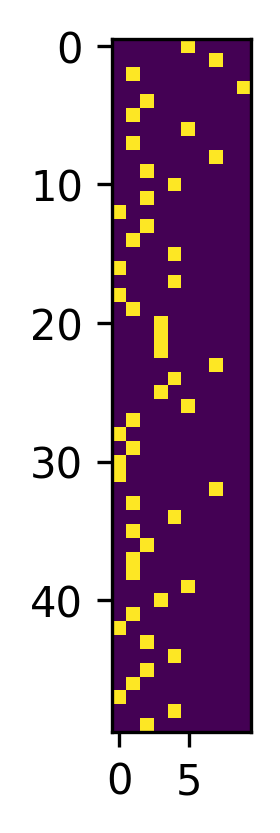

In [6]:
#Visualize the One-hot encoded Prediction Labels
import matplotlib.pyplot as plt
plt.figure(figsize=(9,3), dpi=300)
plt.imshow(y_train[:50])

Apply classification algorithms to the training data, tune on validation data (if present), and evaluate on test data.

You can also apply classification downstream of last week's autoencoder latent space representation.

accuracy: 0.6285714285714286


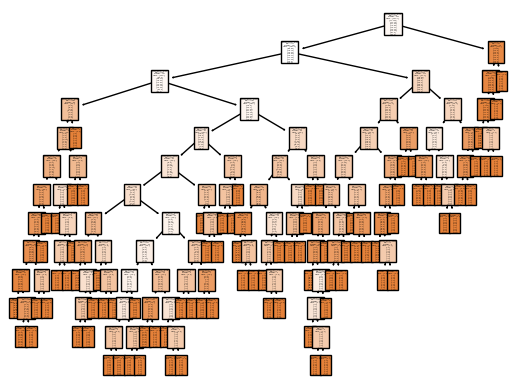

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score
rf = RandomForestClassifier(n_estimators = 300 ,random_state=0)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("accuracy:", acc)
plot_tree(rf.estimators_[0], feature_names=[f'Feature {i}' for i in range(X_train.shape[1])], filled=True)
plt.show()

In [ ]:
print(y_train)
print()
# print(y_test.shape)
torch.argmax(torch.tensor(y_train), dim=1)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]



tensor([5, 7, 1, 9, 2, 1, 5, 1, 7, 2, 4, 2, 0, 2, 1, 4, 0, 4, 0, 1, 3, 3, 3, 7,
        4, 3, 5, 1, 0, 1, 0, 0, 7, 1, 4, 1, 2, 1, 1, 5, 3, 1, 0, 2, 4, 2, 1, 0,
        4, 2, 4, 3, 1, 7, 1, 1, 4, 1, 7, 0, 1, 1, 0, 5, 7, 4, 1, 0, 7, 9, 1, 0,
        4, 1, 1, 4, 4, 0, 2, 4, 4, 1, 1, 3, 4, 0, 1, 1, 7, 8, 5, 1, 1, 1, 0, 2,
        3, 4, 4, 5, 0, 7, 1, 1, 0, 1, 1, 1, 0, 3, 4, 0, 4, 3, 1, 0, 0, 4, 7, 8,
        0, 3, 1, 7, 6, 1, 3, 1, 1, 5, 3, 1, 4, 4, 0, 1, 0, 1, 3, 4, 4, 7, 0, 1,
        1, 2, 1, 0, 4, 1, 1, 4, 0, 0, 4, 6, 5, 1, 5, 1, 4, 3, 3, 4, 6, 3, 1, 3,
        2, 2, 5, 1, 1, 1, 1, 1, 5, 8, 1, 0, 0, 4, 1, 1, 4, 4, 1, 5, 1, 4, 4, 3,
        7, 3, 0, 0, 1, 1, 1, 3, 7, 1, 5, 1, 4, 1, 4, 0, 9, 1, 7, 3, 4, 3, 1, 6,
        1, 1, 5, 1, 7, 3, 3, 1, 0, 3, 1, 4, 4, 3, 1, 2, 1, 3, 1, 5, 1, 0, 3, 0,
        7, 1, 1, 3, 4, 0, 0, 4, 1, 3, 1, 3, 5, 4, 1, 4, 2, 9, 0, 1, 1, 0, 4, 4,
        1, 1, 1, 1, 0, 5, 1, 4, 3, 1, 4, 0, 6, 1, 1, 0, 3, 4, 4, 4, 6, 2, 6, 3,
        0, 1, 0, 4, 5, 3, 1, 1, 0, 0, 1,

In [28]:
# import torch.nn as nn
class NNclass(nn.Module):
  def __init__(self):
    super(NNclass, self).__init__()
    self.layers = nn.Sequential(
        nn.Linear(765, 500),
        nn.ReLU(),
        nn.Linear(500, 250),
        nn.ReLU(),
        nn.Linear(250, 125),
        nn.ReLU(),
        nn.Linear(125, 75),
        nn.ReLU(),
        nn.Linear(75, 10)
    )
    self.softmax = nn.Softmax(dim=1)
  def forward(self, x):
    x = self.layers(x)
    x= self.softmax(x)
    return x



In [86]:
# import torch.nn as nn
class NNtrainer:
  def __init__(self, model, learning_rate, epochs):
    self.model = model
    # num_params = sum(item.numel() for item in model.parameters())
    self.optimizer = torch.optim.Adam(model.parameters(), learning_rate)
    self.epochs = epochs
    # self.loss_func = nn.CrossEntropyLoss()
    # self.loss_func = nn.MSELoss()
    # self.loss_func = F.cross_entropy()

  def train(self, x_train, y_train, x_test, y_test, early_stop=True, verbose=True, draw_curve=True):
    train_loss_list = []
    val_loss_list = []
    train_acc_all = []
    val_acc_all = []

    weights = self.model.state_dict()
    lowest_val_loss = np.inf

    for epoch in tqdm(range(self.epochs), leave=True):
      self.model.train()
      epoch_total_loss = 0.0
      y_pred = self.model(x_train)
      # loss = self.loss_func(y_train, y_pred)
      # loss = F.mse_loss(y_pred, y_train)
      loss = F.cross_entropy(y_pred, y_train)
      # y_pred_np = y_pred.detach().numpy()
      # loss = accuracy_score(y_train, y_pred_np)

      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step()

      epoch_total_loss += loss.detach().cpu().item()

      train_loss_list.append(epoch_total_loss)
      val_loss, _, _, _ = self.evaluate(x_test, y_test)
      val_loss_list.append(val_loss)

      train_acc = self.calculate_accuracy_nn(self.model, x_train, y_train)
      train_acc_all.append(train_acc)


      val_acc = self.calculate_accuracy_nn(self.model, x_test, y_test)
      val_acc_all.append(val_acc)


    _, fpr, tpr, auc_score = self.evaluate(x_test, y_test)
      #early stop
    if early_stop and val_loss < lowest_val_loss:
      lowest_val_loss = val_loss
      weights = self.model.state_dict()
    if early_stop:
      self.model.load_state_dict(weights)

    if draw_curve:
          x_axis = np.arange(self.epochs)
          fig, ax = plt.subplots(1, 1, figsize=(8, 6))
          # print(len(x_axis), len(train_loss_list))
          ax.plot(x_axis, train_loss_list, label="Train Total Loss")
          ax.plot(x_axis, val_loss_list, label="Validation Total Loss")
          ax.set_title("Loss Curves")
          ax.set_xlabel("# Epoch")
          ax.legend()
          self.plot_accuracy(train_acc_all, val_acc_all)
          self.plot_roc_curves(fpr, tpr, auc_score)
    return {
            # "train_total_loss_list": train_loss_list,
            # "val_total_loss_list": val_loss_list,
            "Training accuracy:": (np.mean(train_acc_all)," +/- ",np.std(train_acc_all)),
            "Testing  accuracy:": (np.mean(val_acc_all)," +/- ",np.std(val_acc_all))
        }
  def evaluate(self, x_test, y_test):
        self.model.eval()
        total_loss = 0.0
        tpr_dict = {}
        fpr_dict = {}
        auc_dict = {}
        with torch.no_grad():
          y_preds = self.model(x_test)
          losse = F.cross_entropy(y_preds, y_test)
          total_loss += losse.detach().cpu().item()

          y_preds_np = y_preds.detach().cpu().numpy()
          y_test_np = y_test.detach().cpu().numpy()
          # max_indices = np.argmax(y_preds_np, axis=1)
          # yy=np.eye(y_preds_np.shape[1])[max_indices]

          for class_index in range(y_preds_np.shape[1]):
            y_test_binary = y_test_np[:, class_index]
            y_preds_binary = y_preds_np[:, class_index]

            # Calculate ROC curve for the current class
            fpr, tpr, _ = roc_curve(y_test_binary, y_preds_binary)
            # Calculate AUC for the current class
            auc = roc_auc_score(y_test_binary, y_preds_binary)

            # Store the results in dictionaries
            tpr_dict[class_index] = tpr
            fpr_dict[class_index] = fpr
            auc_dict[class_index] = auc
        return total_loss, fpr_dict, tpr_dict, auc_dict

  def calculate_accuracy_nn(self, model, X, y):
    with torch.no_grad():
        y_pred = torch.argmax(model(X), axis=1)
        y = torch.argmax(y, axis=1)
        acc = torch.sum(y_pred == y) / len(y)
        # print(y_pred, y)
    return acc.detach().numpy()

  def plot_roc_curves(self, fpr_dict, tpr_dict, auc_dict):
      # Number of classes (keys in the dictionaries)
      num_classes = len(fpr_dict)

      fig, axes = plt.subplots(2, 5, figsize=(20, 10), sharex=True, sharey=True)

      # Iterate through each class
      for class_index in range(num_classes):
          # Determine the row and column index for the current class subplot
          row_index = class_index // 5
          col_index = class_index % 5

          ax = axes[row_index, col_index]
          ax.plot(fpr_dict[class_index], tpr_dict[class_index], label=f'Class {class_index} (AUC = {auc_dict[class_index]:.2f})')
          ax.plot([0, 1], [0, 1], 'k--')
          ax.set_xlabel('False Positive Rate')
          ax.set_ylabel('True Positive Rate')
          ax.set_title(f'ROC Curve for Class {class_index}')
          ax.legend(loc='lower right')

      fig.suptitle("ROC Curves for All Classes")
      plt.tight_layout(rect=[0, 0, 1, 0.96])
      plt.show()

  def plot_accuracy(self, train_acc_all, val_acc_all):
        x_axis = np.arange(1, len(train_acc_all) + 1)
        plt.figure(figsize=(8, 6))
        plt.plot(x_axis, train_acc_all, label="Training Accuracy")
        plt.plot(x_axis, val_acc_all, label="Validation Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.title("Training and Validation Accuracy Over Epochs")
        plt.legend()
        plt.show()

100%|██████████| 500/500 [00:40<00:00, 12.21it/s]


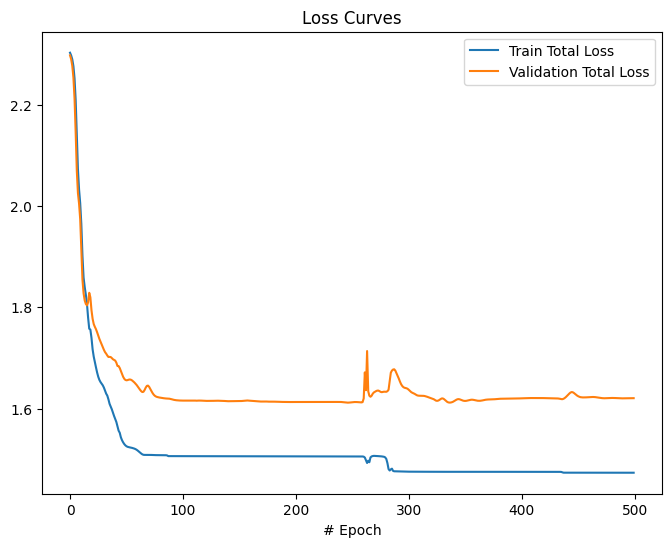

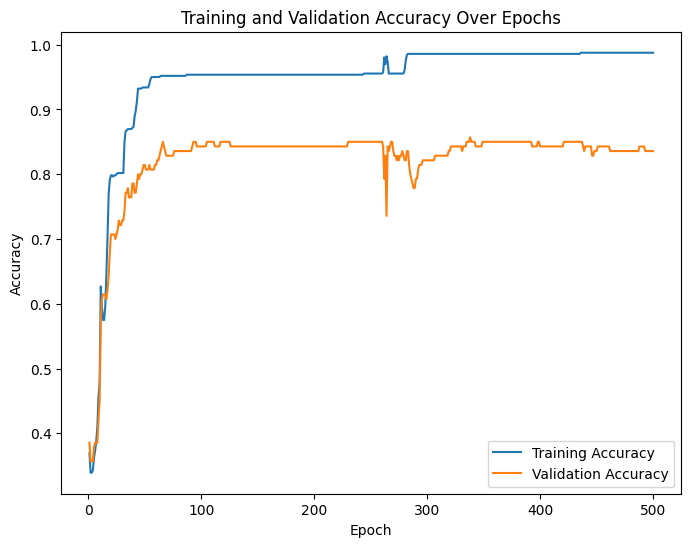

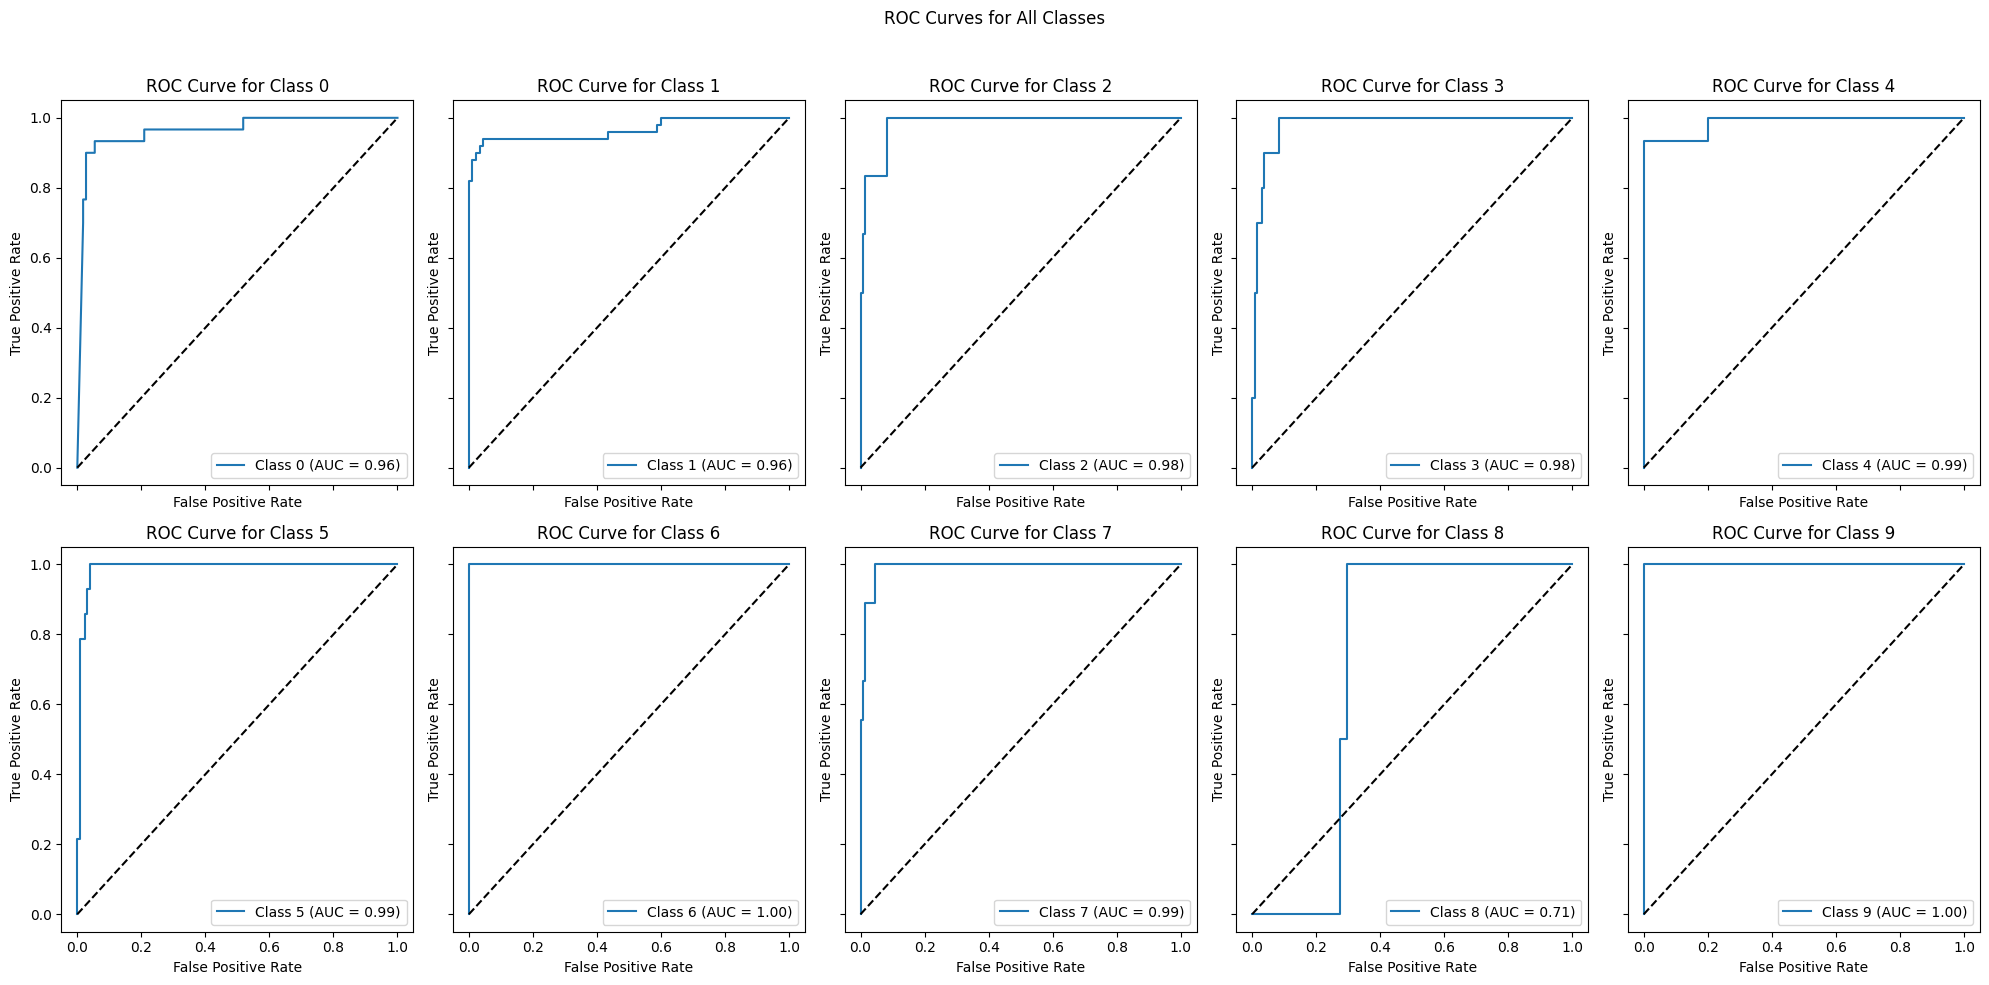

{'Training accuracy:': (0.94533217, ' +/- ', 0.09670261),
 'Testing  accuracy:': (0.82164294, ' +/- ', 0.07306731)}

In [88]:
net = NNclass()
train = NNtrainer(net, 1e-3, 500)
X_train_tens = torch.tensor(X_train, dtype=torch.float32)
X_test_tens = torch.tensor(X_test, dtype=torch.float32)
y_test_tens = torch.tensor(y_test, dtype=torch.float32)
y_train_tens = torch.tensor(y_train, dtype=torch.float32)
train.train(X_train_tens, y_train_tens, X_test_tens, y_test_tens, draw_curve=True)

In [104]:
class encoderclass(nn.Module):
  def __init__(self):
    super(encoderclass, self).__init__()
    self.encoder = nn.Sequential(
        nn.Linear(765, 500),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(500, 250),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(250, 125),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(125, 75),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(75, 10)
    )

    self.decoder = nn.Sequential(
        nn.Linear(10, 75),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(75, 125),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(125, 250),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(250, 500),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(500, 765)
    )
    # self.softmax = nn.Softmax(dim=1)
  def forward(self, x):
    z = self.encoder(x)
    x_recon = self.decoder(z)
    # x= self.softmax(x)
    return x_recon, z

class classification(nn.Module):
  def __init__(self):
    super().__init__()
    self.classe = nn.Sequential(
            nn.Linear(10, 10),  # Assuming 10 classes
            nn.Softmax(dim=1)
        )

  def forward(self, z):
    # print("z shape",z.shape)
    return self.classe(z)


class AEClass(nn.Module):
    def __init__(self, ae, classification_model):
        super(AEClass, self).__init__()
        self.ae = ae
        self.classification_model = classification_model

    def forward(self, x):
        # Forward pass through VAE
        x_recon, z = self.ae(x)
        classification_output = self.classification_model(z)
        return x_recon, classification_output

In [112]:
class encodertrainer:
  def __init__(self, model, learning_rate, epochs):
    self.model = model
    # num_params = sum(item.numel() for item in model.parameters())
    self.optimizer = torch.optim.Adam(model.parameters(), learning_rate)
    self.epochs = epochs

  def train(self, x_train, y_train, x_test, y_test, early_stop=True, verbose=True, draw_curve=True):
    train_loss_list = []
    val_loss_list = []
    train_acc_all = []
    val_acc_all = []
    train_class_loss_list = []
    val_class_loss_list = []

    weights = self.model.state_dict()
    lowest_val_loss = np.inf

    for epoch in tqdm(range(self.epochs), leave=True):
      self.model.train()
      epoch_total_loss = 0.0
      epoch_class_loss = 0.0
      x_recon, y_pred = self.model(x_train)
      class_loss = F.cross_entropy(y_pred, y_train)
      ae_loss = F.mse_loss(x_recon, x_train)
      total_loss = class_loss + ae_loss

      self.optimizer.zero_grad()
      total_loss.backward()
      self.optimizer.step()

      epoch_total_loss += total_loss.detach().cpu().item()
      epoch_class_loss += class_loss.detach().cpu().item()

      train_loss_list.append(epoch_total_loss)
      train_class_loss_list.append(epoch_class_loss)

      val_loss, val_class_loss, _, _, _ = self.evaluate(x_test, y_test)
      val_loss_list.append(val_loss)
      val_class_loss_list.append(val_class_loss)


      train_acc = self.calculate_accuracy_nn(self.model, x_train, y_train)
      train_acc_all.append(train_acc)


      val_acc = self.calculate_accuracy_nn(self.model, x_test, y_test)
      val_acc_all.append(val_acc)


    _,_, fpr, tpr, auc_score = self.evaluate(x_test, y_test)
      #early stop
    if early_stop and val_loss < lowest_val_loss:
      lowest_val_loss = val_loss
      weights = self.model.state_dict()
    if early_stop:
      self.model.load_state_dict(weights)

    if draw_curve:
          x_axis = np.arange(self.epochs)
          fig, ax = plt.subplots(1, 1, figsize=(8, 6))
          # print(len(x_axis), len(train_loss_list))
          ax.plot(x_axis, train_loss_list, label="Train Total Loss")
          ax.plot(x_axis, val_loss_list, label="Validation Total Loss")
          ax.set_title("Loss Curves")
          ax.set_xlabel("# Epoch")
          ax.legend()
          self.plot_accuracy(train_acc_all, val_acc_all)
          self.plot_roc_curves(fpr, tpr, auc_score)
    return {
            # "train_total_loss_list": train_loss_list,
            # "val_total_loss_list": val_loss_list,
            "Training accuracy:": (np.mean(train_acc_all)," +/- ",np.std(train_acc_all)),
            "Testing  accuracy:": (np.mean(val_acc_all)," +/- ",np.std(val_acc_all))
        }
  def evaluate(self, x_test, y_test):
        self.model.eval()
        total_loss = 0.0
        tpr_dict = {}
        fpr_dict = {}
        auc_dict = {}
        with torch.no_grad():
          x_recon, y_preds = self.model(x_test)
          class_loss = F.cross_entropy(y_preds, y_test)
          ae_loss = F.mse_loss(x_recon, x_test)
          total_loss += class_loss.detach().cpu().item() + ae_loss.detach().cpu().item()

          y_preds_np = y_preds.detach().cpu().numpy()
          y_test_np = y_test.detach().cpu().numpy()
          # max_indices = np.argmax(y_preds_np, axis=1)
          # yy=np.eye(y_preds_np.shape[1])[max_indices]

          for class_index in range(y_preds_np.shape[1]):
            y_test_binary = y_test_np[:, class_index]
            y_preds_binary = y_preds_np[:, class_index]

            # Calculate ROC curve for the current class
            fpr, tpr, _ = roc_curve(y_test_binary, y_preds_binary)
            # Calculate AUC for the current class
            auc = roc_auc_score(y_test_binary, y_preds_binary)

            # Store the results in dictionaries
            tpr_dict[class_index] = tpr
            fpr_dict[class_index] = fpr
            auc_dict[class_index] = auc
        return total_loss, ae_loss, fpr_dict, tpr_dict, auc_dict

  def calculate_accuracy_nn(self, model, X, y):
    with torch.no_grad():
        _, y_pred = model(X)
        y_pred = torch.argmax(y_pred, axis=1)
        y = torch.argmax(y, axis=1)
        acc = torch.sum(y_pred == y) / len(y)
        # print(y_pred, y)
    return acc.detach().numpy()

  def plot_roc_curves(self, fpr_dict, tpr_dict, auc_dict):
      # Number of classes (keys in the dictionaries)
      num_classes = len(fpr_dict)

      fig, axes = plt.subplots(2, 5, figsize=(20, 10), sharex=True, sharey=True)

      # Iterate through each class
      for class_index in range(num_classes):
          # Determine the row and column index for the current class subplot
          row_index = class_index // 5
          col_index = class_index % 5

          ax = axes[row_index, col_index]
          ax.plot(fpr_dict[class_index], tpr_dict[class_index], label=f'Class {class_index} (AUC = {auc_dict[class_index]:.2f})')
          ax.plot([0, 1], [0, 1], 'k--')
          ax.set_xlabel('False Positive Rate')
          ax.set_ylabel('True Positive Rate')
          ax.set_title(f'ROC Curve for Class {class_index}')
          ax.legend(loc='lower right')

      fig.suptitle("ROC Curves for All Classes")
      plt.tight_layout(rect=[0, 0, 1, 0.96])
      plt.show()

  def plot_accuracy(self, train_acc_all, val_acc_all):
        x_axis = np.arange(1, len(train_acc_all) + 1)
        plt.figure(figsize=(8, 6))
        plt.plot(x_axis, train_acc_all, label="Training Accuracy")
        plt.plot(x_axis, val_acc_all, label="Validation Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.title("Training and Validation Accuracy Over Epochs")
        plt.legend()
        plt.show()

100%|██████████| 500/500 [01:18<00:00,  6.38it/s]


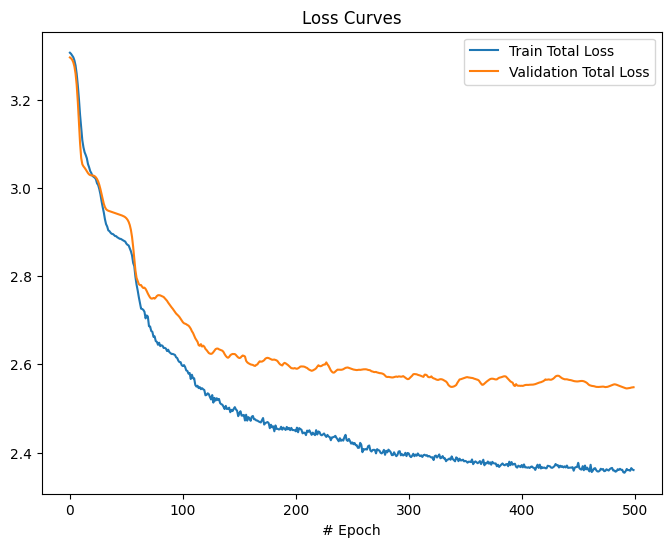

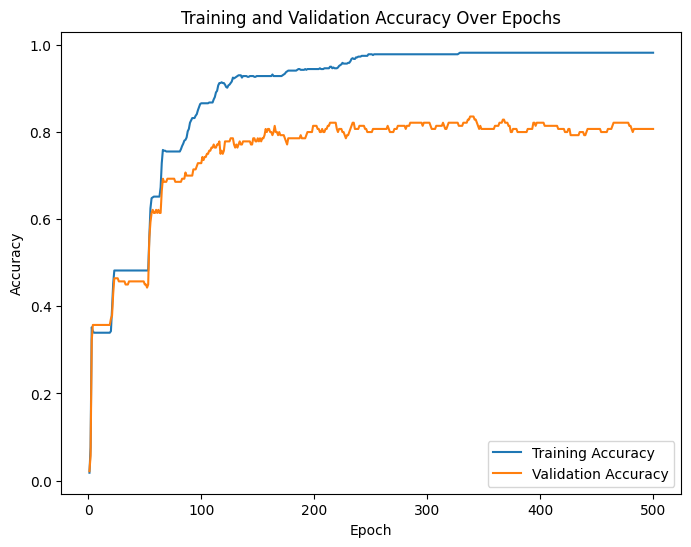

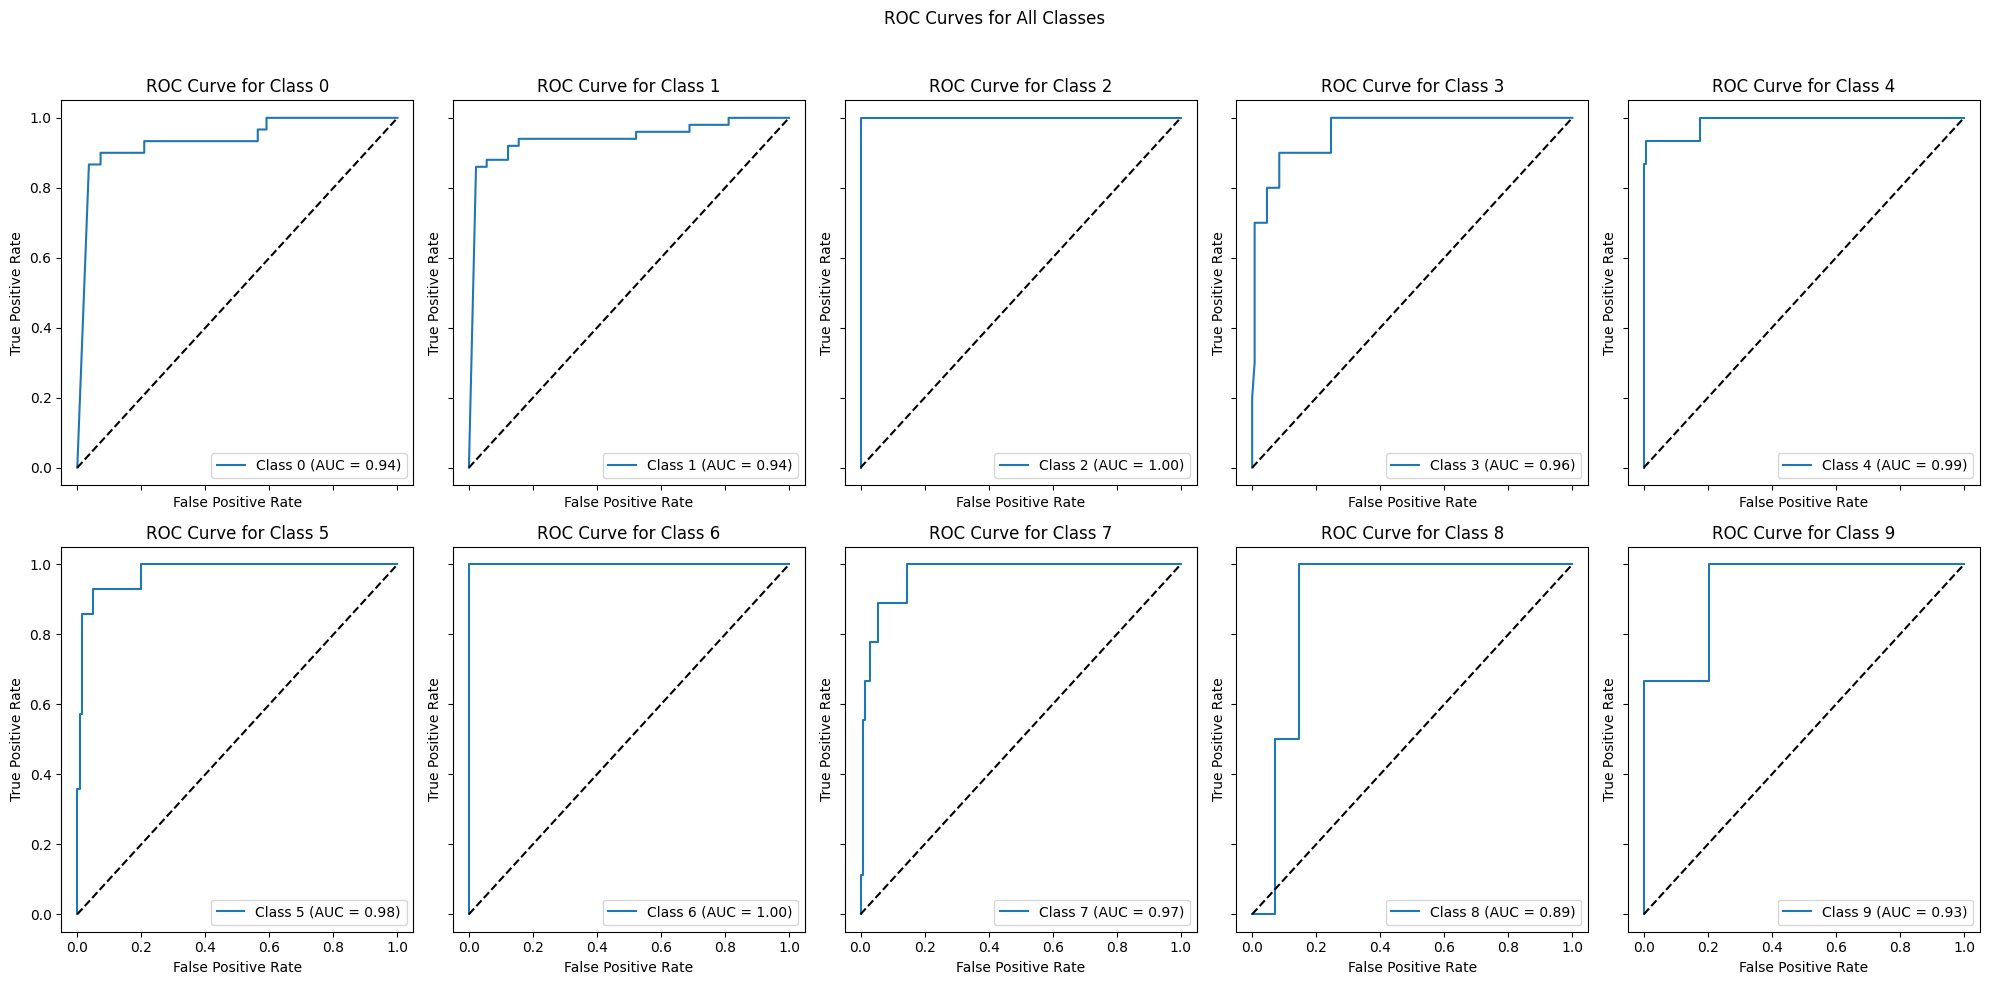

{'Training accuracy:': (0.8855786, ' +/- ', 0.17905642),
 'Testing  accuracy:': (0.74931425, ' +/- ', 0.12892625)}

In [114]:
encode = encoderclass()
classif = classification()
ae = AEClass(encode, classif)
train = encodertrainer(ae, 1e-3, 500)
train.train(X_train_tens, y_train_tens, X_test_tens, y_test_tens, draw_curve=True)